# Tutorial 3: Redshift Distributions and Cosmological Models

## Introduction

Understanding redshift distributions is crucial for weak lensing analysis because:

1. **Lensing efficiency** depends on the distance to both lens and source
2. **Redshift binning** allows analysis of different galaxy populations
3. **Cosmological modeling** requires accurate distance-redshift relations

In this tutorial, you'll learn to work with galaxy redshift distributions and set up cosmological models for lensing calculations.

### Learning Objectives

By the end of this tutorial, you will:
1. Extract and analyze redshift distributions from galaxy catalogues
2. Use Gaussian Mixture Models (GMM) to bin galaxies by redshift
3. Understand the relationship between redshift and lensing efficiency
4. Set up cosmological models using PyCC
5. Calculate weak lensing kernels and efficiency functions

### Prerequisites

- Completion of Tutorials 1 and 2
- Basic understanding of cosmological distances
- Familiarity with Gaussian distributions

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import healpy as hp

# Try to import cosmological tools
try:
    import pyccl as ccl
    print('✅ PyCC (Core Cosmology Library) imported successfully')
    CCL_AVAILABLE = True
except ImportError:
    print('⚠️  PyCC not found. Install with: pip install pyccl')
    print('   Some cosmological calculations will be simulated')
    CCL_AVAILABLE = False

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print('🌌 Tutorial 3: Redshift Distributions and Cosmology')
print('📦 All packages imported successfully')

✅ PyCC (Core Cosmology Library) imported successfully
🌌 Tutorial 3: Redshift Distributions and Cosmology
📦 All packages imported successfully


## Part 1: Loading and Examining Redshift Data

Let's start by loading our galaxy catalogue and examining its redshift distribution:

In [2]:
# Load galaxy catalogue
try:
    catalogue = np.load('catalogue_1000sqd.npy', allow_pickle=True)
    # catalogue = np.load("catalogue.npy", allow_pickle=True)
    print(f"📁 Loaded catalogue with {len(catalogue):,} galaxies")
    
    # Extract redshift data
    z_data = catalogue['z']
    
    # Basic redshift statistics
    print(f"\n📊 Redshift Statistics:")
    print(f"  Range: {z_data.min():.3f} - {z_data.max():.3f}")
    print(f"  Mean: {z_data.mean():.3f}")
    print(f"  Median: {np.median(z_data):.3f}")
    print(f"  Standard deviation: {z_data.std():.3f}")
    
    CATALOGUE_AVAILABLE = True
    
except FileNotFoundError:
    print("❌ catalogue.npy not found. Creating synthetic redshift data for demonstration.")
    
    # Create synthetic redshift distribution for demonstration
    np.random.seed(42)
    n_galaxies = 50000
    
    # Multi-component redshift distribution (common in real surveys)
    z1 = np.random.normal(0.3, 0.1, int(0.4 * n_galaxies))  # Low-z peak
    z2 = np.random.normal(0.7, 0.2, int(0.4 * n_galaxies))  # Mid-z peak
    z3 = np.random.exponential(0.3, int(0.2 * n_galaxies)) + 1.0  # High-z tail
    
    z_data = np.concatenate([z1, z2, z3])
    z_data = z_data[z_data > 0]  # Remove negative redshifts
    z_data = z_data[z_data < 3.0]  # Set reasonable upper limit
    
    print(f"📁 Created synthetic redshift data with {len(z_data):,} galaxies")
    print(f"  Range: {z_data.min():.3f} - {z_data.max():.3f}")
    print(f"  Mean: {z_data.mean():.3f}")
    
    CATALOGUE_AVAILABLE = False

📁 Loaded catalogue with 31,574,550 galaxies

📊 Redshift Statistics:
  Range: 0.001 - 5.981
  Mean: 2.253
  Median: 2.146
  Standard deviation: 1.055


### Visualizing the Redshift Distribution

The redshift distribution n(z) tells us how many galaxies we observe at each distance:

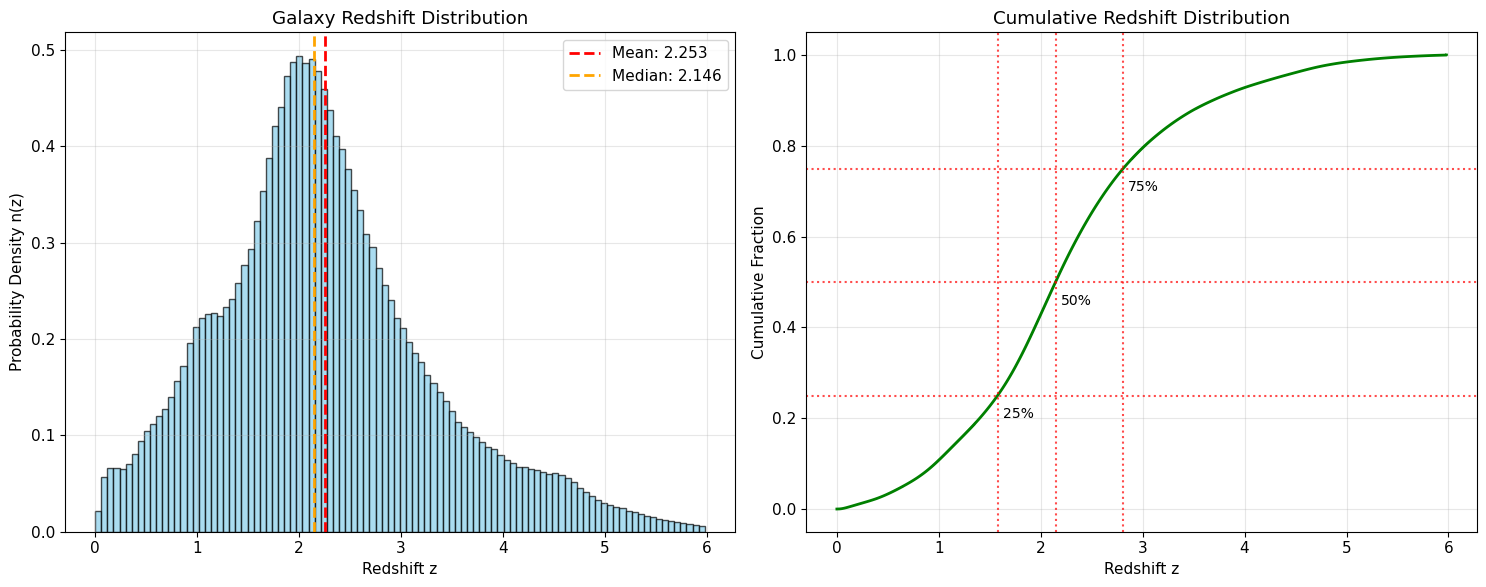


🔍 Key percentiles:
  10th percentile: z = 0.964
  25th percentile: z = 1.578
  50th percentile: z = 2.146
  75th percentile: z = 2.810
  90th percentile: z = 3.686


In [3]:
# Plot the redshift distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of redshifts
ax1.hist(z_data, bins=100, alpha=0.7, color='skyblue', edgecolor='black', density=True)
ax1.set_xlabel('Redshift z')
ax1.set_ylabel('Probability Density n(z)')
ax1.set_title('Galaxy Redshift Distribution')
ax1.grid(True, alpha=0.3)

# Add some statistics to the plot
ax1.axvline(np.mean(z_data), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(z_data):.3f}')
ax1.axvline(np.median(z_data), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(z_data):.3f}')
ax1.legend()

# Cumulative distribution
z_sorted = np.sort(z_data)
cumulative = np.arange(1, len(z_sorted) + 1) / len(z_sorted)
ax2.plot(z_sorted, cumulative, linewidth=2, color='green')
ax2.set_xlabel('Redshift z')
ax2.set_ylabel('Cumulative Fraction')
ax2.set_title('Cumulative Redshift Distribution')
ax2.grid(True, alpha=0.3)

# Add percentile lines
percentiles = [25, 50, 75]
for p in percentiles:
    z_p = np.percentile(z_data, p)
    ax2.axhline(p/100, color='red', linestyle=':', alpha=0.7)
    ax2.axvline(z_p, color='red', linestyle=':', alpha=0.7)
    ax2.text(z_p + 0.05, p/100 - 0.05, f'{p}%', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n🔍 Key percentiles:")
for p in [10, 25, 50, 75, 90]:
    print(f"  {p}th percentile: z = {np.percentile(z_data, p):.3f}")

## Part 2: Gaussian Mixture Model for Redshift Binning

We'll use a Gaussian Mixture Model (GMM) to identify distinct redshift populations and create redshift bins. This is useful for:

1. **Tomographic analysis**: Studying lensing at different distances
2. **Population identification**: Separating different galaxy types
3. **Improved modeling**: Accounting for complex redshift distributions

### Setting Up the GMM

In [4]:
# Set up Gaussian Mixture Model
n_components = 5  # Number of Gaussian components

# Reshape data for sklearn (needs 2D array)
data = z_data.reshape(-1, 1)

# Define initial means for better convergence
# Space them evenly across the redshift range
z_min, z_max = z_data.min(), z_data.max()
initial_means = np.linspace(z_min + 0.1, z_max - 0.1, n_components).reshape(-1, 1)

print(f"🧮 Setting up Gaussian Mixture Model:")
print(f"  Number of components: {n_components}")
print(f"  Initial means: {initial_means.flatten()}")

# Fit GMM with manually initialized means
gmm = GaussianMixture(n_components=n_components, 
                     means_init=initial_means, 
                     random_state=42,
                     max_iter=200)

print(f"\n🔄 Fitting GMM to {len(data):,} galaxies...")
gmm.fit(data)

print(f"✅ GMM fit completed!")
print(f"  Converged: {gmm.converged_}")
print(f"  Number of iterations: {gmm.n_iter_}")
print(f"  Log-likelihood: {gmm.score(data):.2f}")

🧮 Setting up Gaussian Mixture Model:
  Number of components: 5
  Initial means: [0.101     1.5460174 2.991035  4.4360523 5.8810697]

🔄 Fitting GMM to 31,574,550 galaxies...
✅ GMM fit completed!
  Converged: True
  Number of iterations: 8
  Log-likelihood: -1.43


### Analyzing GMM Results

In [5]:
# Extract GMM parameters
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_

print(f"📊 GMM Component Analysis:")
print(f"{'Component':<12} {'Mean z':<10} {'Std Dev':<10} {'Weight':<10} {'Fraction':<12}")
print("-" * 60)

for i in range(n_components):
    std_dev = np.sqrt(covariances[i])
    fraction = weights[i] * 100
    print(f"{i+1:<12} {means[i]:<10.3f} {std_dev:<10.3f} {weights[i]:<10.3f} {fraction:<12.1f}%")

# Get component assignments for each galaxy
probabilities = gmm.predict_proba(data)  # Probability of belonging to each component
labels = gmm.predict(data)               # Most likely component

# For soft assignment (probabilistic), we can also randomly assign based on probabilities
soft_labels = np.array([np.random.choice(n_components, p=prob) for prob in probabilities])

print(f"\n🏷️  Galaxy Assignment:")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  Component {label+1}: {count:,} galaxies ({count/len(data)*100:.1f}%)")

📊 GMM Component Analysis:
Component    Mean z     Std Dev    Weight     Fraction    
------------------------------------------------------------
1            0.579      0.292      0.073      7.3         %
2            1.798      0.534      0.534      53.4        %
3            2.739      0.497      0.277      27.7        %
4            4.115      0.555      0.105      10.5        %
5            5.373      0.318      0.011      1.1         %

🏷️  Galaxy Assignment:
  Component 1: 2,285,501 galaxies (7.2%)
  Component 2: 17,741,122 galaxies (56.2%)
  Component 3: 8,106,806 galaxies (25.7%)
  Component 4: 3,107,142 galaxies (9.8%)
  Component 5: 333,979 galaxies (1.1%)


### Visualizing the GMM Fit

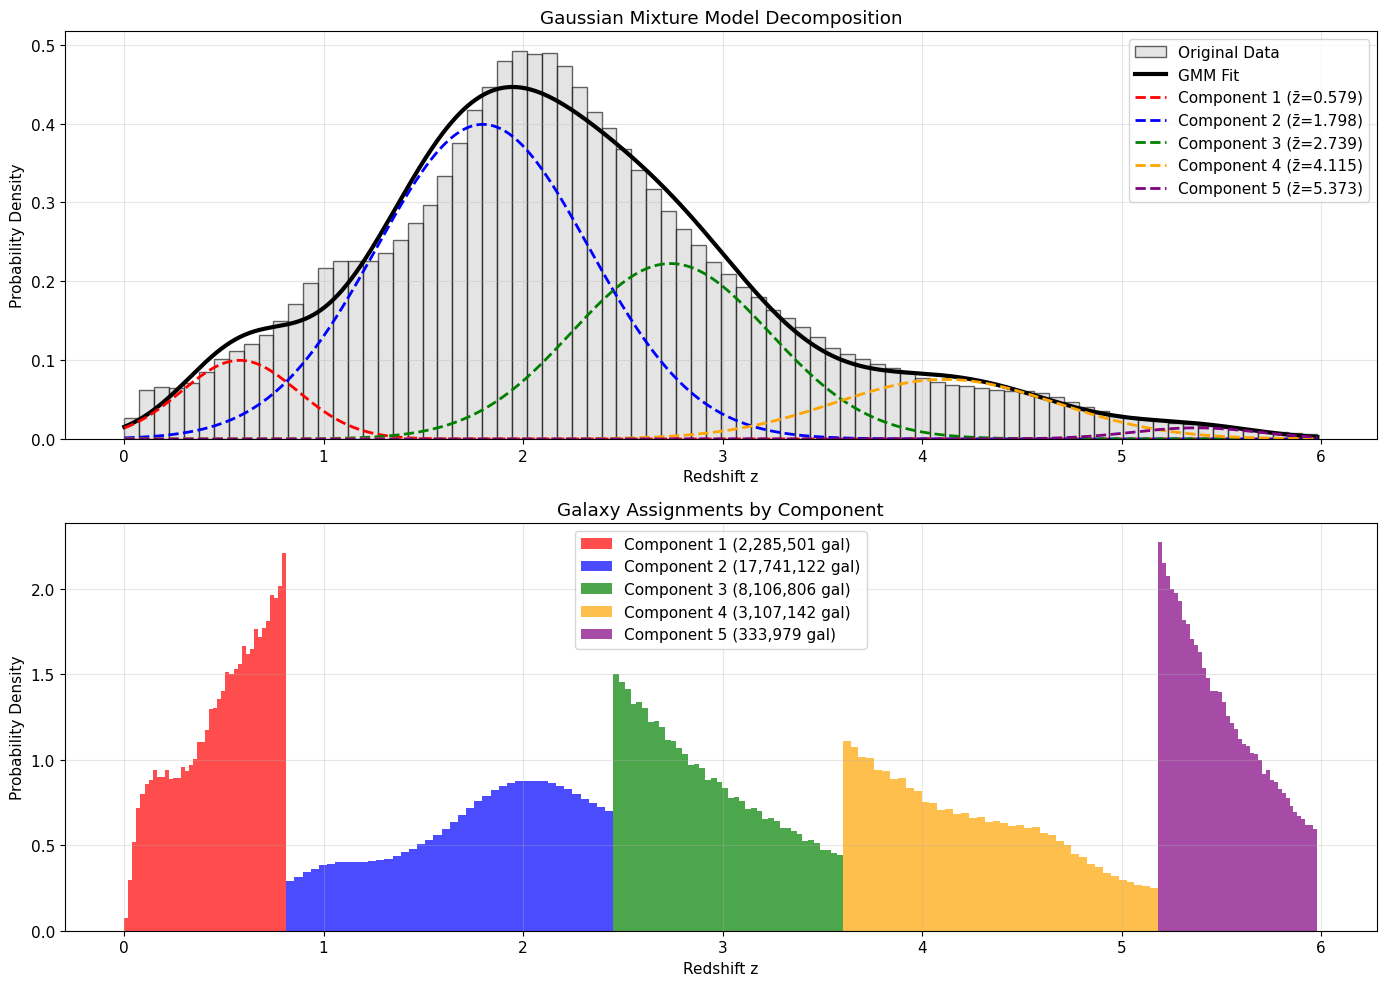


💡 The GMM has successfully decomposed the redshift distribution into
   5 components, representing different galaxy populations.


In [6]:
# Create visualization of GMM fit
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Original data with GMM components
z_range = np.linspace(z_data.min(), z_data.max(), 1000).reshape(-1, 1)

# Plot original histogram
ax1.hist(z_data, bins=80, alpha=0.6, density=True, color='lightgray', 
         edgecolor='black', label='Original Data')

# Plot overall GMM fit
total_density = np.exp(gmm.score_samples(z_range))
ax1.plot(z_range, total_density, 'black', linewidth=3, label='GMM Fit')

# Plot individual components
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(n_components):
    component_density = weights[i] * norm.pdf(z_range.flatten(), means[i], np.sqrt(covariances[i]))
    ax1.plot(z_range, component_density, colors[i % len(colors)], linewidth=2, 
             linestyle='--', label=f'Component {i+1} (z̄={means[i]:.3f})')

ax1.set_xlabel('Redshift z')
ax1.set_ylabel('Probability Density')
ax1.set_title('Gaussian Mixture Model Decomposition')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Galaxy assignments by component
for i in range(n_components):
    mask = labels == i
    if np.any(mask):
        ax2.hist(z_data[mask], bins=40, alpha=0.7, density=True,
                color=colors[i % len(colors)], 
                label=f'Component {i+1} ({np.sum(mask):,} gal)')

ax2.set_xlabel('Redshift z')
ax2.set_ylabel('Probability Density')
ax2.set_title('Galaxy Assignments by Component')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 The GMM has successfully decomposed the redshift distribution into")
print(f"   {n_components} components, representing different galaxy populations.")

## Part 3: Cosmological Modeling with PyCC

Now we'll set up a cosmological model to calculate lensing quantities. This involves:

1. **Defining cosmological parameters** (Ωₘ, Ωᵦ, h, σ₈, etc.)
2. **Creating distance-redshift relations**
3. **Setting up weak lensing tracers**
4. **Computing angular power spectra**

### Setting Up the Cosmology

In [7]:
# Define cosmological parameters (typical Planck 2018 values)
omega_m = 0.31      # Total matter density
omega_b = 0.049     # Baryon density  
omega_c = omega_m - omega_b  # Cold dark matter density
h = 0.67            # Hubble parameter H₀ = 100h km/s/Mpc
sigma8 = 0.81       # Amplitude of matter fluctuations
n_s = 0.96          # Spectral index

print(f"🌌 Cosmological Parameters:")
print(f"  Ωₘ = {omega_m} (total matter)")
print(f"  Ωᵦ = {omega_b} (baryons)")
print(f"  Ωc = {omega_c} (cold dark matter)")
print(f"  h = {h} (H₀ = {h*100} km/s/Mpc)")
print(f"  σ₈ = {sigma8} (fluctuation amplitude)")
print(f"  nₛ = {n_s} (spectral index)")

if CCL_AVAILABLE:
    # Create CCL cosmology object
    cosmo = ccl.Cosmology(
        Omega_c=omega_c, 
        Omega_b=omega_b, 
        h=h, 
        sigma8=sigma8, 
        n_s=n_s
    )
    
    print(f"\n✅ CCL Cosmology object created successfully")
    print(f"  Ωₖ = {cosmo['Omega_k']:.4f} (curvature)")
    print(f"  ΩΛ = {1 - cosmo['Omega_m']:.4f} (dark energy)")
    
else:
    print(f"\n⚠️  CCL not available - will simulate cosmological calculations")
    cosmo = None

🌌 Cosmological Parameters:
  Ωₘ = 0.31 (total matter)
  Ωᵦ = 0.049 (baryons)
  Ωc = 0.261 (cold dark matter)
  h = 0.67 (H₀ = 67.0 km/s/Mpc)
  σ₈ = 0.81 (fluctuation amplitude)
  nₛ = 0.96 (spectral index)

✅ CCL Cosmology object created successfully
  Ωₖ = 0.0000 (curvature)
  ΩΛ = 0.6900 (dark energy)


### Understanding Lensing Efficiency

The lensing efficiency function describes how effective lensing is for galaxies at different redshifts. It depends on:

- **Source redshift distribution**: Where the lensed galaxies are
- **Lens redshift**: Where the lensing matter is
- **Cosmological distances**: Angular diameter distances

In [8]:
# Select one redshift bin for detailed analysis
selected_bin = 2  # Choose component with reasonable statistics
bin_mask = labels == selected_bin
bin_galaxies = z_data[bin_mask]

print(f"🔍 Analyzing Component {selected_bin + 1}:")
print(f"  Number of galaxies: {np.sum(bin_mask):,}")
print(f"  Mean redshift: {means[selected_bin]:.3f}")
print(f"  Standard deviation: {np.sqrt(covariances[selected_bin]):.3f}")
print(f"  Redshift range: {bin_galaxies.min():.3f} - {bin_galaxies.max():.3f}")

if CCL_AVAILABLE:
    # Create redshift array for calculations
    z_array = np.linspace(0.001, 3.0, 1000)
    
    # Create normalized redshift distribution for this bin
    # Use the GMM component as the true distribution
    nz = norm.pdf(z_array, means[selected_bin], np.sqrt(covariances[selected_bin]))
    nz = nz / np.trapz(nz, z_array)  # Normalize
    
    # Create weak lensing tracer
    lens_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z_array, nz))
    
    print(f"\n✅ Created weak lensing tracer for component {selected_bin + 1}")
    
else:
    # Simulate the process
    z_array = np.linspace(0.001, 3.0, 1000)
    nz = norm.pdf(z_array, means[selected_bin], np.sqrt(covariances[selected_bin]))
    nz = nz / np.trapz(nz, z_array)
    lens_tracer = None
    
    print(f"\n⚠️  Simulating lensing tracer creation for component {selected_bin + 1}")

🔍 Analyzing Component 3:
  Number of galaxies: 8,106,806
  Mean redshift: 2.739
  Standard deviation: 0.497
  Redshift range: 2.453 - 3.601

✅ Created weak lensing tracer for component 3


/var/folders/yv/7v74fslx3c75zq5f_4bcwblm0000gn/T/ipykernel_17106/3515898412.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nz = nz / np.trapz(nz, z_array)  # Normalize


### Visualizing the Redshift Distribution and Lensing Kernel

/var/folders/yv/7v74fslx3c75zq5f_4bcwblm0000gn/T/ipykernel_17106/384769650.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  efficiency[i] = np.trapz(nz[mask_behind] * (z_array[mask_behind] - zl) / z_array[mask_behind],


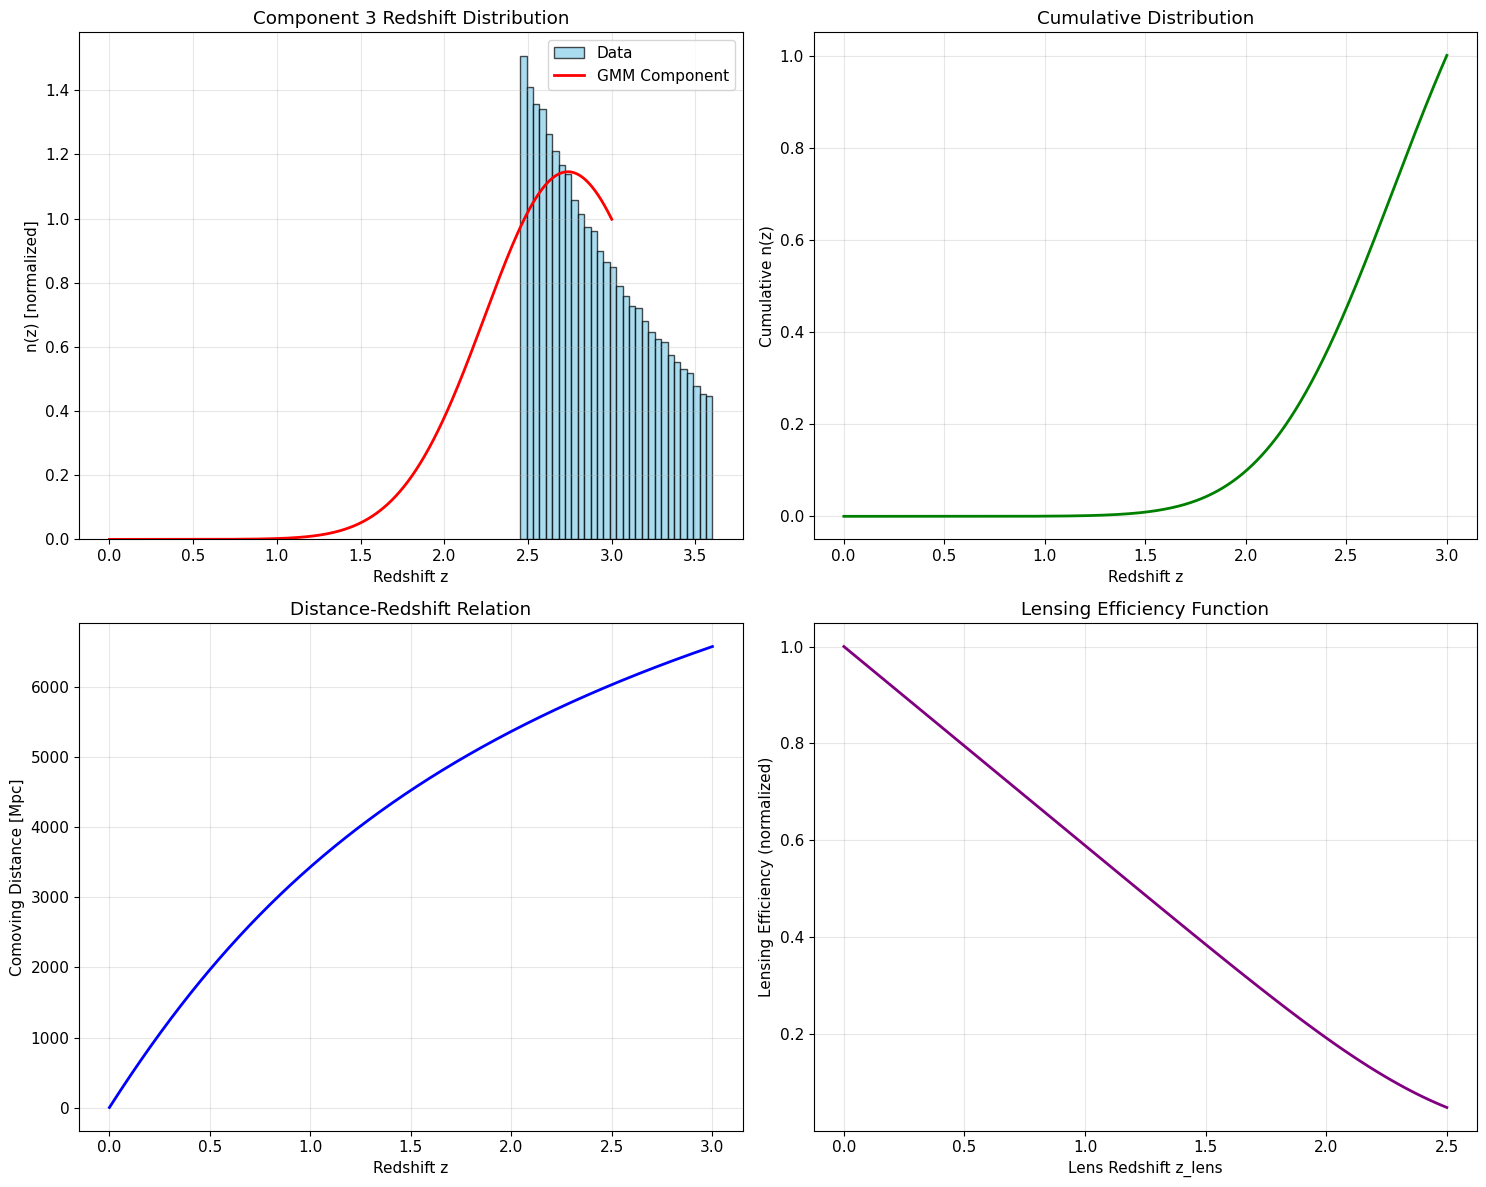


🔍 Key Insights:
  • Peak lensing efficiency occurs at z_lens ≈ 0.00
  • This is roughly half the mean source redshift (2.739)
  • Lensing is most effective when lenses are at intermediate distances


In [9]:
# Plot the selected redshift bin and its properties
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Redshift distribution for selected bin
ax1.hist(bin_galaxies, bins=30, alpha=0.7, density=True, 
         color='skyblue', edgecolor='black', label='Data')
ax1.plot(z_array, nz, 'red', linewidth=2, label='GMM Component')
ax1.set_xlabel('Redshift z')
ax1.set_ylabel('n(z) [normalized]')
ax1.set_title(f'Component {selected_bin + 1} Redshift Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cumulative distribution
cumulative_nz = np.cumsum(nz) * (z_array[1] - z_array[0])
ax2.plot(z_array, cumulative_nz, 'green', linewidth=2)
ax2.set_xlabel('Redshift z')
ax2.set_ylabel('Cumulative n(z)')
ax2.set_title('Cumulative Distribution')
ax2.grid(True, alpha=0.3)

# 3. Distance-redshift relation
if CCL_AVAILABLE:
    # Comoving distance
    chi = ccl.comoving_radial_distance(cosmo, 1/(1+z_array))
    ax3.plot(z_array, chi, 'blue', linewidth=2)
    ax3.set_xlabel('Redshift z')
    ax3.set_ylabel('Comoving Distance [Mpc]')
    ax3.set_title('Distance-Redshift Relation')
else:
    # Approximate distance relation for demonstration
    c = 299792.458  # km/s
    H0 = h * 100    # km/s/Mpc
    chi_approx = c/H0 * z_array  # Linear approximation
    ax3.plot(z_array, chi_approx, 'blue', linewidth=2, linestyle='--')
    ax3.set_xlabel('Redshift z')
    ax3.set_ylabel('Distance [Mpc] (approx)')
    ax3.set_title('Approximate Distance-Redshift')

ax3.grid(True, alpha=0.3)

# 4. Lensing efficiency (simplified)
# The lensing efficiency peaks when lenses are roughly halfway to sources
z_lens = np.linspace(0, 2.5, 100)
efficiency = np.zeros_like(z_lens)

for i, zl in enumerate(z_lens):
    # Sources behind this lens redshift
    mask_behind = z_array > zl
    if np.any(mask_behind):
        # Weight by source distribution and geometric factor
        efficiency[i] = np.trapz(nz[mask_behind] * (z_array[mask_behind] - zl) / z_array[mask_behind], 
                               z_array[mask_behind])

ax4.plot(z_lens, efficiency / np.max(efficiency), 'purple', linewidth=2)
ax4.set_xlabel('Lens Redshift z_lens')
ax4.set_ylabel('Lensing Efficiency (normalized)')
ax4.set_title('Lensing Efficiency Function')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🔍 Key Insights:")
print(f"  • Peak lensing efficiency occurs at z_lens ≈ {z_lens[np.argmax(efficiency)]:.2f}")
print(f"  • This is roughly half the mean source redshift ({means[selected_bin]:.3f})")
print(f"  • Lensing is most effective when lenses are at intermediate distances")

## Part 4: Computing Angular Power Spectra

The angular power spectrum C_ℓ describes the statistical properties of the convergence field. It's fundamental for:

1. **Theoretical predictions** of lensing signals
2. **Map generation** using tools like `hp.synfast()`
3. **Cosmological parameter estimation**

In [10]:
# Set up angular scales (multipoles)
ell = np.arange(2, 10000)  # Angular multipoles

print(f"🔢 Computing angular power spectrum:")
print(f"  Multipole range: ℓ = {ell.min()} to {ell.max()}")
print(f"  Angular scales: {180/ell.max():.3f}° to {180/ell.min():.1f}°")

if CCL_AVAILABLE and lens_tracer is not None:
    # Compute the angular power spectrum for weak lensing
    print(f"\n🔄 Computing C_ℓ^κκ using CCL...")
    cl_kappa = ccl.angular_cl(cosmo, lens_tracer, lens_tracer, ell)
    
    print(f"✅ Power spectrum computed successfully")
    print(f"  C_ℓ range: {cl_kappa.min():.2e} to {cl_kappa.max():.2e}")
    
    # Save the power spectrum
    output_filename = f'cl_kappa_mean_{means[selected_bin]:.2f}.txt'
    np.savetxt(output_filename, np.column_stack((ell, cl_kappa)), 
               header=f'ell C_l_kappa for redshift bin {selected_bin+1}, mean z = {means[selected_bin]:.3f}')
    print(f"💾 Saved power spectrum to {output_filename}")
    
else:
    # Load existing power spectrum or create a model
    try:
        print(f"\n📁 Loading existing power spectrum from cl_kappa.txt...")
        cl_kappa_data = np.loadtxt("cl_kappa.txt")
        
        # Interpolate to our ell range if needed
        if len(cl_kappa_data) != len(ell):
            from scipy.interpolate import interp1d
            ell_file = np.arange(2, len(cl_kappa_data) + 2)
            interp_func = interp1d(ell_file, cl_kappa_data, 
                                 bounds_error=False, fill_value='extrapolate')
            cl_kappa = interp_func(ell)
        else:
            cl_kappa = cl_kappa_data
        
        print(f"✅ Loaded power spectrum with {len(cl_kappa)} multipoles")
        
    except FileNotFoundError:
        print(f"❌ cl_kappa.txt not found. Creating model power spectrum...")
        
        # Create a realistic model power spectrum
        # This is a simplified model for demonstration
        ell_pivot = 1000
        amplitude = 1e-7
        slope = -1.5
        
        cl_kappa = amplitude * (ell / ell_pivot) ** slope
        print(f"✅ Created model power spectrum")

🔢 Computing angular power spectrum:
  Multipole range: ℓ = 2 to 9999
  Angular scales: 0.018° to 90.0°

🔄 Computing C_ℓ^κκ using CCL...
✅ Power spectrum computed successfully
  C_ℓ range: 4.89e-11 to 8.05e-08
💾 Saved power spectrum to cl_kappa_mean_2.74.txt


### Visualizing the Angular Power Spectrum

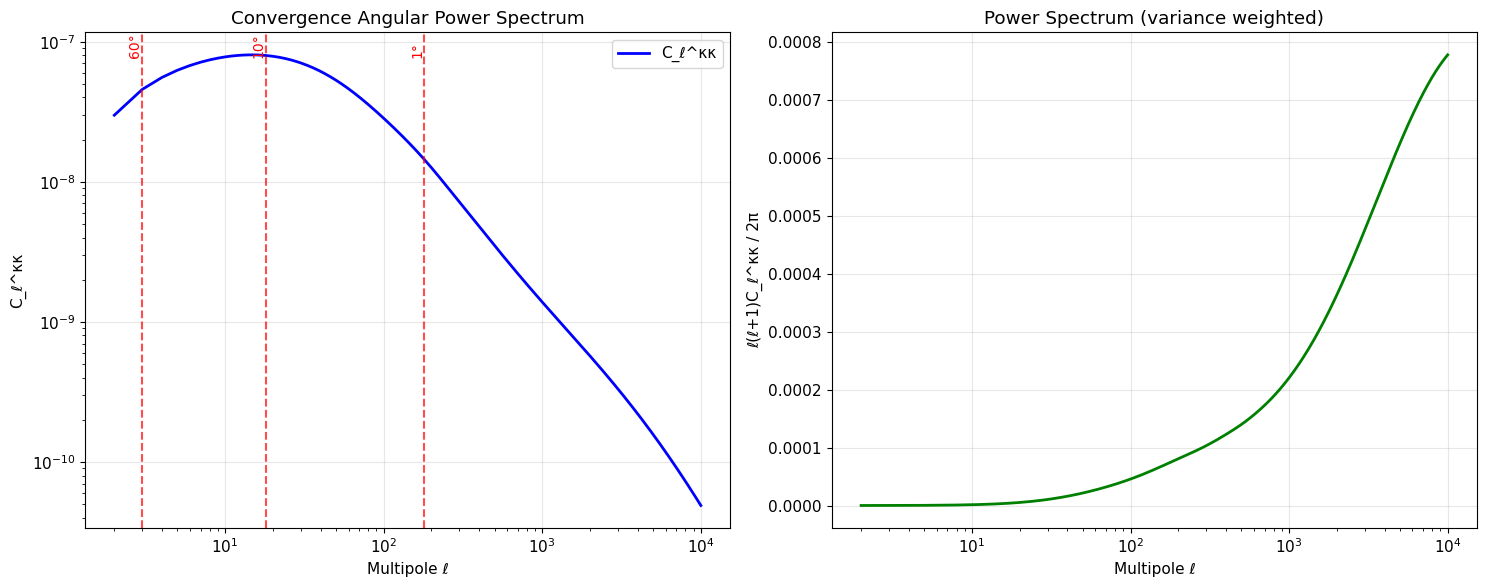


📊 Power Spectrum Analysis:
  Peak contribution at ℓ ≈ 9999
  Corresponding angular scale: 0.02°
  Total power (ℓ=2-1000): 1.01e-05

🎯 This power spectrum is for:
  Redshift bin: Component 3
  Mean redshift: 2.739
  Galaxy population: 8,106,806 galaxies


/var/folders/yv/7v74fslx3c75zq5f_4bcwblm0000gn/T/ipykernel_17106/296523127.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"  Total power (ℓ=2-1000): {np.trapz(cl_kappa[:999], ell[:999]):.2e}")


In [11]:
# Plot the angular power spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Power spectrum in log-log scale
ax1.loglog(ell, cl_kappa, 'b-', linewidth=2, label='C_ℓ^κκ')
ax1.set_xlabel('Multipole ℓ')
ax1.set_ylabel('C_ℓ^κκ')
ax1.set_title('Convergence Angular Power Spectrum')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add angular scale annotations
angular_scales = [1, 10, 60]  # degrees, arcminutes
for scale in angular_scales:
    ell_scale = 180 / scale
    if ell_scale >= ell.min() and ell_scale <= ell.max():
        ax1.axvline(ell_scale, color='red', linestyle='--', alpha=0.7)
        ax1.text(ell_scale, cl_kappa.max(), f'{scale}°', rotation=90, 
                fontsize=10, color='red', ha='right')

# Multipole times power spectrum (shows contribution to variance)
ax2.semilogx(ell, ell * (ell + 1) * cl_kappa / (2 * np.pi), 'g-', linewidth=2)
ax2.set_xlabel('Multipole ℓ')
ax2.set_ylabel('ℓ(ℓ+1)C_ℓ^κκ / 2π')
ax2.set_title('Power Spectrum (variance weighted)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some key statistics
peak_ell = ell[np.argmax(ell * (ell + 1) * cl_kappa)]
peak_scale = 180 / peak_ell

print(f"\n📊 Power Spectrum Analysis:")
print(f"  Peak contribution at ℓ ≈ {peak_ell:.0f}")
print(f"  Corresponding angular scale: {peak_scale:.2f}°")
print(f"  Total power (ℓ=2-1000): {np.trapz(cl_kappa[:999], ell[:999]):.2e}")

# Print information about the redshift bin
print(f"\n🎯 This power spectrum is for:")
print(f"  Redshift bin: Component {selected_bin + 1}")
print(f"  Mean redshift: {means[selected_bin]:.3f}")
print(f"  Galaxy population: {np.sum(bin_mask):,} galaxies")

## Part 5: Cross-Bin Analysis

Real weak lensing analyses often look at correlations between different redshift bins. This provides additional cosmological information:

🔍 Cross-Bin Analysis for All Components:
Bin   Mean z   N_gal    Fraction   z_eff   
---------------------------------------------
1     0.579    2,285,501 7.2       % 0.495   
2     1.798    17,741,122 56.2      % 1.773   
3     2.739    8,106,806 25.7      % 2.911   
4     4.115    3,107,142 9.8       % 4.224   
5     5.373    333,979  1.1       % 5.496   


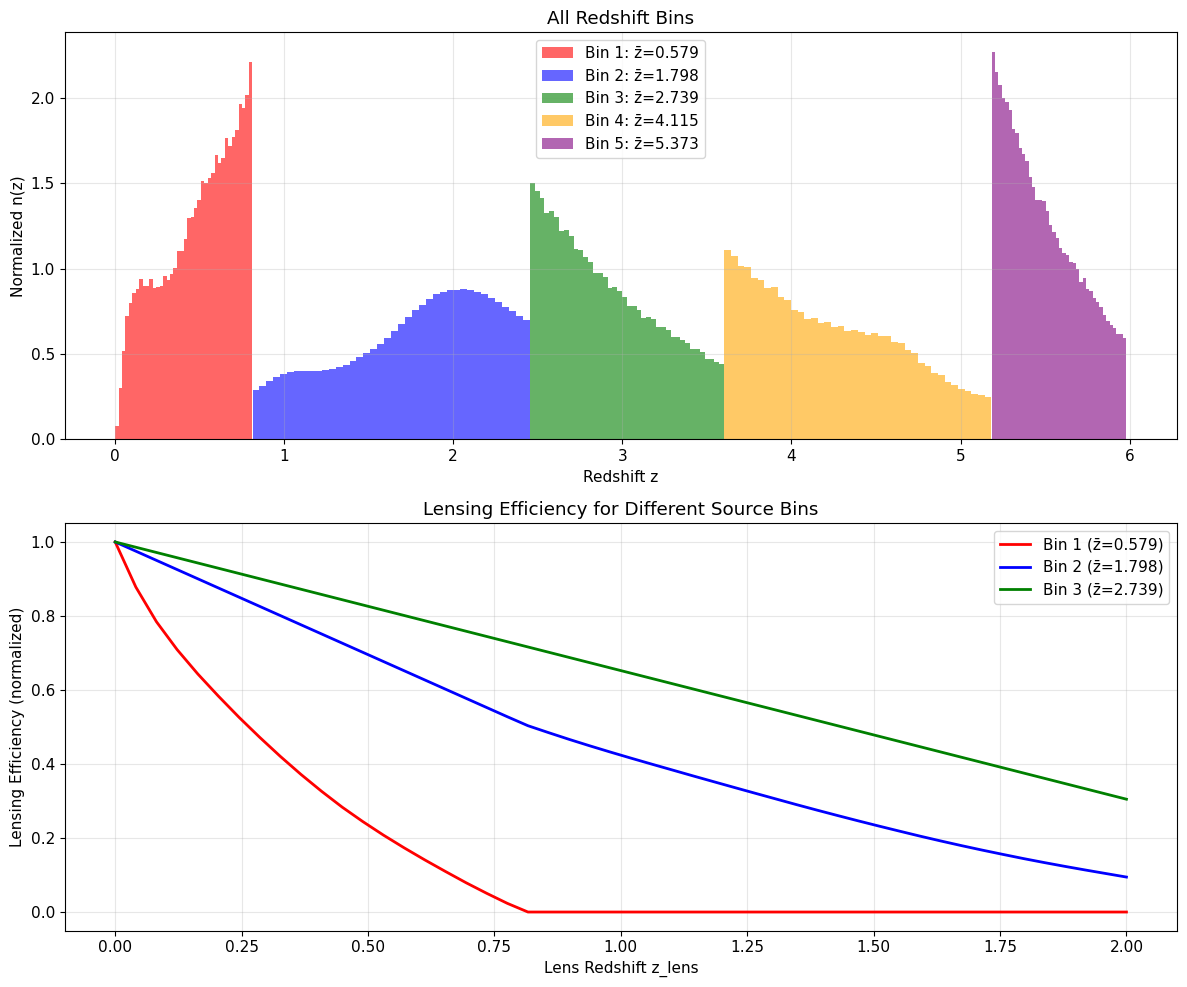


💡 Cross-bin correlations allow us to:
  • Test cosmological models with multiple distance scales
  • Reduce systematic errors through redundancy
  • Improve parameter constraints


In [12]:
# Analyze all redshift bins
print(f"🔍 Cross-Bin Analysis for All Components:")
print(f"{'Bin':<5} {'Mean z':<8} {'N_gal':<8} {'Fraction':<10} {'z_eff':<8}")
print("-" * 45)

bin_info = []
for i in range(n_components):
    mask = labels == i
    n_gal = np.sum(mask)
    fraction = n_gal / len(labels) * 100
    z_eff = np.mean(z_data[mask]) if n_gal > 0 else 0
    
    print(f"{i+1:<5} {means[i]:<8.3f} {n_gal:<8,} {fraction:<10.1f}% {z_eff:<8.3f}")
    
    bin_info.append({
        'bin': i+1,
        'mean_z': means[i],
        'n_galaxies': n_gal,
        'fraction': fraction,
        'z_effective': z_eff
    })

# Create redshift distribution plot for all bins
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# All bins on one plot
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(n_components):
    mask = labels == i
    if np.sum(mask) > 0:
        ax1.hist(z_data[mask], bins=40, alpha=0.6, density=True,
                color=colors[i % len(colors)], 
                label=f'Bin {i+1}: z̄={means[i]:.3f}')

ax1.set_xlabel('Redshift z')
ax1.set_ylabel('Normalized n(z)')
ax1.set_title('All Redshift Bins')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lensing efficiency comparison
z_lens_range = np.linspace(0, 2.0, 50)

for i in range(min(3, n_components)):  # Show first 3 bins to avoid clutter
    mask = labels == i
    if np.sum(mask) > 100:  # Only bins with sufficient galaxies
        z_sources = z_data[mask]
        efficiency = []
        
        for zl in z_lens_range:
            # Simple lensing efficiency calculation
            sources_behind = z_sources[z_sources > zl]
            if len(sources_behind) > 0:
                # Geometric lensing efficiency
                eff = np.mean((sources_behind - zl) / sources_behind)
            else:
                eff = 0
            efficiency.append(eff)
        
        efficiency = np.array(efficiency)
        if np.max(efficiency) > 0:
            efficiency = efficiency / np.max(efficiency)  # Normalize
        
        ax2.plot(z_lens_range, efficiency, colors[i % len(colors)], 
                linewidth=2, label=f'Bin {i+1} (z̄={means[i]:.3f})')

ax2.set_xlabel('Lens Redshift z_lens')
ax2.set_ylabel('Lensing Efficiency (normalized)')
ax2.set_title('Lensing Efficiency for Different Source Bins')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Cross-bin correlations allow us to:")
print(f"  • Test cosmological models with multiple distance scales")
print(f"  • Reduce systematic errors through redundancy")
print(f"  • Improve parameter constraints")

## Summary and Next Steps

### What We've Accomplished

1. **Redshift Analysis**: Extracted and analyzed galaxy redshift distributions
2. **GMM Modeling**: Used Gaussian Mixture Models to identify redshift populations
3. **Cosmological Setup**: Configured PyCC for lensing calculations
4. **Power Spectra**: Computed angular power spectra for different redshift bins
5. **Cross-bin Analysis**: Explored correlations between different galaxy populations

### Key Concepts

- **Redshift distributions** n(z) describe galaxy distance distributions
- **Gaussian Mixture Models** can decompose complex redshift distributions
- **Lensing efficiency** depends on the geometry of lens-source configurations
- **Angular power spectra** encode the statistical properties of convergence fields
- **Cross-bin correlations** provide additional cosmological information

### Next Tutorial Preview

In **Tutorial 4: Power Spectra and Convergence Maps**, you will learn:
- How to generate convergence maps from power spectra
- Understanding different map-making techniques (Gaussian vs lognormal)
- Validating generated maps against theoretical expectations
- Preparing convergence maps for forward modeling

In [13]:
# Tutorial completion summary
print("📋 TUTORIAL 3 COMPLETED")
print("=" * 50)
print("✅ Analyzed galaxy redshift distributions")
print("✅ Implemented Gaussian Mixture Model decomposition")
print("✅ Set up cosmological models with PyCC")
print("✅ Computed angular power spectra")
print("✅ Performed cross-bin lensing efficiency analysis")
print("✅ Generated power spectra for different redshift bins")

print(f"\n📊 Results Summary:")
print(f"  • {n_components} redshift components identified")
print(f"  • Primary component: z̄ = {means[selected_bin]:.3f} ({np.sum(labels==selected_bin):,} galaxies)")
print(f"  • Power spectrum: ℓ = {ell.min()}-{ell.max()}, C_ℓ range: {cl_kappa.min():.2e}-{cl_kappa.max():.2e}")

if CCL_AVAILABLE:
    print(f"  • Full cosmological modeling with PyCC")
else:
    print(f"  • Demonstrated workflow (install PyCC for full functionality)")

print("\n🚀 Ready for Tutorial 4: Power Spectra and Convergence Map Generation")

📋 TUTORIAL 3 COMPLETED
✅ Analyzed galaxy redshift distributions
✅ Implemented Gaussian Mixture Model decomposition
✅ Set up cosmological models with PyCC
✅ Computed angular power spectra
✅ Performed cross-bin lensing efficiency analysis
✅ Generated power spectra for different redshift bins

📊 Results Summary:
  • 5 redshift components identified
  • Primary component: z̄ = 2.739 (8,106,806 galaxies)
  • Power spectrum: ℓ = 2-9999, C_ℓ range: 4.89e-11-8.05e-08
  • Full cosmological modeling with PyCC

🚀 Ready for Tutorial 4: Power Spectra and Convergence Map Generation
